In [1]:
%config InlineBackend.rc = {'figure.figsize': (10,6)}
%matplotlib inline

## Poisson equation with getfem

This example solves the Poisson problem using [getfem](https://getfem.org/) using data generated by Nanomesh. We solve the Poisson problem $-\Delta u = 1$ with the boundary condition $u=0$.

This an adaptation of [Python getfem demo](https://getfem-examples.readthedocs.io/en/latest/demo_unit_disk.html).

### Setup getfem

First, we must setup the path to the python module ([link](https://getfem.org/python/pygf.html#introduction)), so that getfem can be used in our Nanomesh environment.

We import getfem and generate a mesh to test if it works.

In [2]:
import sys
sys.path.append('../../../getfem/interface/src/python/')

import getfem
m = getfem.Mesh('cartesian', range(0, 3), range(0,3))
print(m)


BEGIN POINTS LIST

  POINT COUNT 9
  POINT  0  0  0
  POINT  1  1  0
  POINT  2  2  0
  POINT  3  0  1
  POINT  4  1  1
  POINT  5  2  1
  POINT  6  0  2
  POINT  7  1  2
  POINT  8  2  2

END POINTS LIST



BEGIN MESH STRUCTURE DESCRIPTION

  CONVEX COUNT 4
  CONVEX 0    'GT_LINEAR_PRODUCT(GT_PK(1,1),GT_PK(1,1))'      0  1  3  4
  CONVEX 1    'GT_LINEAR_PRODUCT(GT_PK(1,1),GT_PK(1,1))'      1  2  4  5
  CONVEX 2    'GT_LINEAR_PRODUCT(GT_PK(1,1),GT_PK(1,1))'      3  4  6  7
  CONVEX 3    'GT_LINEAR_PRODUCT(GT_PK(1,1),GT_PK(1,1))'      4  5  7  8

END MESH STRUCTURE DESCRIPTION



### Generate some data

We use the 2D binary blobs data to generate a triangle mesh. The triangles that belong to the blobs are removed.

<AxesSubplot:title={'center':'triangle mesh'}>

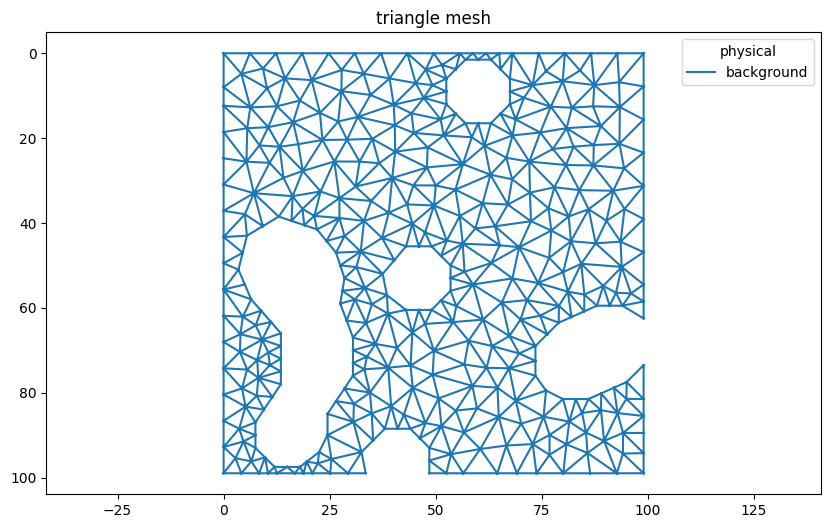

In [3]:
from skimage.morphology import disk
from nanomesh.data import binary_blobs2d

data = binary_blobs2d(length=100, seed=96)

from nanomesh import Mesher

mesher = Mesher(data)
mesher.generate_contour(max_edge_dist=3, precision=1)
mesh = mesher.triangulate(opts='q30a25')

triangles = mesh.get('triangle')
triangles.remove_cells(label=2, key='physical')

triangles.plot()

### Convert to getfem mesh type

We use the *2D triangulation* [mesh type](https://getfem-examples.readthedocs.io/en/latest/ball_eigen.html?highlight=mesh#Mesh-generation) described by passing the argument `pt2D`. Note that the points and cells arrays must be transposed.


In [4]:
import getfem as gf

p = triangles.points.T
t = triangles.cells.T

mesh = gf.Mesh('pt2D', p, t)
print(mesh)


BEGIN POINTS LIST

  POINT COUNT 389
  POINT  0  16.5  63
  POINT  1  16.5  60
  POINT  2  16.5  57
  POINT  3  14.25  54.75
  POINT  4  12  52.5
  POINT  5  9  52.5
  POINT  6  6  52.5
  POINT  7  3.75  54.75
  POINT  8  1.5  57
  POINT  9  1.5  60
  POINT  10  1.5  63
  POINT  11  3.75  65.25
  POINT  12  6  67.5
  POINT  13  9  67.5
  POINT  14  12  67.5
  POINT  15  14.25  65.25
  POINT  16  97.5  18
  POINT  17  97.5  15
  POINT  18  97.5  12
  POINT  19  95.25  9.75
  POINT  20  93  7.5
  POINT  21  90  7.5
  POINT  22  87  7.5
  POINT  23  84  9.5
  POINT  24  81  11.5
  POINT  25  78  13.5
  POINT  26  75  13.5
  POINT  27  72  13.5
  POINT  28  69  13.5
  POINT  29  66  13.5
  POINT  30  63.33333333333334  11.16666666666667
  POINT  31  60.66666666666666  8.833333333333332
  POINT  32  58  6.5
  POINT  33  54.5  5
  POINT  34  51  3.5
  POINT  35  47  4.5
  POINT  36  43  5.5
  POINT  37  40.75  9.25
  POINT  38  38.5  13
  POINT  39  39.5  16
  POINT  40  40.5  19
  POINT  4

### Poisson's equation

The next cell shows how to solve the Poisson equation. This code was re-used from [here](https://getfem-examples.readthedocs.io/en/latest/demo_unit_disk.html).

In [5]:
import getfem as gf
import numpy as np

OUTER_BOUND = 1

outer_faces = mesh.outer_faces()
mesh.set_region(OUTER_BOUND, outer_faces)

sl = gf.Slice(("none",), mesh, 1)

elements_degree = 2

mfu = gf.MeshFem(mesh, 1)
mfu.set_classical_fem(elements_degree)

mim = gf.MeshIm(mesh, pow(elements_degree, 2))

F = 1.0

md = gf.Model("real")

md.add_fem_variable("u", mfu)
md.add_Laplacian_brick(mim, "u")
md.add_fem_data("F", mfu)
md.set_variable("F", np.repeat(F, mfu.nbdof()))
md.add_source_term_brick(mim, "u", "F")
md.add_Dirichlet_condition_with_multipliers(mim, "u", elements_degree - 1, OUTER_BOUND)

md.solve()

Trace 2 in getfem_models.cc, line 4401: Mass term assembly for Dirichlet condition
Trace 2 in getfem_models.cc, line 3478: Laplacian: generic matrix assembly
Trace 2 in getfem_models.cc, line 3310: Generic source term assembly
Trace 2 in getfem_models.cc, line 3321: Source term: generic source term assembly
Trace 2 in getfem_models.cc, line 4401: Mass term assembly for Dirichlet condition


(0, 1)

### Display result using PyVista

The data can be visualized by saving to a vtk file, and loading that with [PyVista](https://docs.pyvista.org/).

In [6]:
import pyvista as pv

U = md.variable("u")
sl.export_to_vtk("u.vtk", "ascii", mfu, U, "U")

m = pv.read("u.vtk")
contours = m.contour()

p = pv.Plotter()
p.add_mesh(m, show_edges=False)
p.add_mesh(contours, color="black", line_width=1)
p.add_mesh(m.contour(8).extract_largest(), opacity=0.1)
p.show(cpos="xy")

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)